In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 

from ChemClean import *
from Descriptors import *

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [4]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,CCC(C)c1cc(C)c(NC)c2nsnc12,1.45
1,CCCN(C)c1c2c(c(C(C)C)c3nsnc13)C1CCC2CC1,1.33
2,CCCc1c2c(c(C(C)C)c3nsnc13)C1CCC2C1,1.34
3,CCC1COc2c(cc3nsnc3c2N(C)C(C)CC)O1,1.35
4,CCCN1CN(C)c2c1c(NC)c1nsnc1c2C,1.22


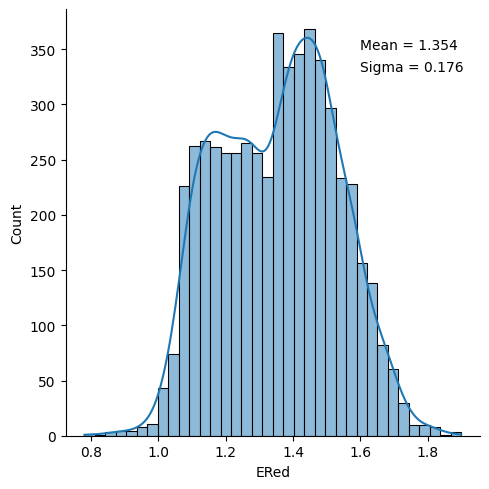

In [5]:
ax=sns.displot(data, x="ERed",kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [6]:
%%time
p=desc(data['SMILES'][:5000])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5000, 208)
CPU times: user 31.5 s, sys: 286 ms, total: 31.7 s
Wall time: 31.7 s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.427963,0.537969,4.427963,0.537969,0.883646,235.356,218.220,235.114319,86,0,...,0,0,0,0,0,0,0,0,0,0
1,4.745614,0.527807,4.745614,0.527807,0.750129,329.513,302.297,329.192569,124,0,...,0,0,0,0,0,0,0,0,0,0
2,4.674446,0.560349,4.674446,0.560349,0.781169,286.444,264.268,286.150370,106,0,...,0,0,0,0,0,0,0,0,0,0
3,6.047968,0.114166,6.047968,0.114166,0.865233,307.419,286.251,307.135448,114,0,...,0,0,0,0,0,0,0,0,0,0
4,4.470303,0.939216,4.470303,0.939216,0.934155,277.397,258.245,277.136117,102,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [7]:
p=clean(df_rdkit)

In [8]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)
print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5000, 208)
After: df.shape=(5000, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5000, 208)
After: df.shape=(5000, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5000, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.427963,0.537969,235.356,1.375000,9.944261,-1.987954,2.723542,-1.16,11.033401,0.000000,...,0.000000,6.570159,1.934566,1,0,0,0,1,1,0
1,4.745614,0.527807,329.513,1.043478,9.636956,-2.285737,2.073456,-1.16,11.033401,0.000000,...,2.451759,8.003745,2.245264,0,0,0,0,0,3,0
2,4.674446,0.560349,286.444,1.100000,9.798788,-2.091372,2.101330,-0.96,11.033401,0.000000,...,0.000000,6.918017,0.000000,0,0,0,0,1,6,0
3,6.047968,0.114166,307.419,1.428571,10.115612,-2.320878,2.145530,-1.56,29.431636,11.499024,...,2.220436,7.072553,2.081186,0,1,0,0,0,2,0
4,4.470303,0.939216,277.397,1.263158,10.075693,-2.284239,2.323025,-1.56,11.033401,0.000000,...,4.729074,6.365118,4.109864,1,1,0,0,1,2,0


In [23]:
target=data['ERed'][:5000]
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.427963,0.537969,235.356,1.375000,9.944261,-1.987954,2.723542,-1.16,11.033401,0.000000,...,0.000000,6.570159,1.934566,1,0,0,0,1,1,0
1,4.745614,0.527807,329.513,1.043478,9.636956,-2.285737,2.073456,-1.16,11.033401,0.000000,...,2.451759,8.003745,2.245264,0,0,0,0,0,3,0
2,4.674446,0.560349,286.444,1.100000,9.798788,-2.091372,2.101330,-0.96,11.033401,0.000000,...,0.000000,6.918017,0.000000,0,0,0,0,1,6,0
3,6.047968,0.114166,307.419,1.428571,10.115612,-2.320878,2.145530,-1.56,29.431636,11.499024,...,2.220436,7.072553,2.081186,0,1,0,0,0,2,0
4,4.470303,0.939216,277.397,1.263158,10.075693,-2.284239,2.323025,-1.56,11.033401,0.000000,...,4.729074,6.365118,4.109864,1,1,0,0,1,2,0


## Feature elimination using p-value test; using Linear Regression

### p-values calculated using ordinary least squares fit

In [24]:
mod = sm.OLS(target,features)
fii = mod.fit()
fii.summary2().tables[1].head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
MaxEStateIndex,0.031523,0.002720,11.591313,1.129580e-30,0.026191,0.036854
MinEStateIndex,0.025417,0.009249,2.748055,6.016672e-03,0.007285,0.043550
MolWt,-0.006145,0.000603,-10.192025,3.717893e-24,-0.007327,-0.004963
FpDensityMorgan1,0.044070,0.011781,3.740624,1.856362e-04,0.020973,0.067166
BCUT2D_MWLOW,0.017480,0.011906,1.468185,1.421175e-01,-0.005861,0.040821


### Recursive elimination of all features whose p-value < alpha (=0.02)

In [25]:
alpha=0.02
for a in range(len(features.columns)):
    mod = sm.OLS(target,features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>alpha:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
features.columns

6 descriptors eliminated in iteration 1
Final model has (5000, 33) desriptors


Index(['MaxEStateIndex', 'MinEStateIndex', 'MolWt', 'FpDensityMorgan1',
       'BCUT2D_LOGPLOW', 'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5',
       'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6',
       'EState_VSA7', 'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

In [41]:
%store features
%store target

Stored 'features' (DataFrame)
Stored 'target' (Series)
